# Modeling

### Import Relevant Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [2]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.drop(['index'],axis=1,inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Data columns (total 99 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player                       4209 non-null   object 
 1   report                       4209 non-null   object 
 2   year                         4209 non-null   float64
 3   weight_x                     3986 non-null   float64
 4   height_x                     3986 non-null   float64
 5   pos_rk                       3871 non-null   float64
 6   ovr_rk                       3292 non-null   float64
 7   grade                        3877 non-null   float64
 8   age                          3897 non-null   float64
 9   Round                        4209 non-null   Int64  
 10  Pick                         4209 non-null   Int64  
 11  target                       4209 non-null   Int64  
 12  processed_report             4209 non-null   object 
 13  reportlen         

In [6]:
df['target'] = df.Round

In [7]:
df.target[df.target >= 6] = 0

In [8]:
df.target[df.target == 1] = 10

In [9]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [10]:
df.target[df.target == 3] = 2

In [11]:
df.target[df.target == 10] = 3

In [12]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [13]:
cleaned_df = cleaned_df.add_suffix('_col')

In [14]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


In [15]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.025,max_df =.75)

In [16]:
X = tf.fit_transform(df.joined_report)

In [17]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [18]:
report_df.columns

Index(['2001', '2002', '2003', '2004', '2005', '2006', '2006 draft', '2007',
       '2014', '2015',
       ...
       'work ethic', 'worth', 'would', 'yard', 'yard averag', 'yard per',
       'yard touchdown', 'year', 'year starter', 'zone'],
      dtype='object', length=519)

In [19]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [20]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,work ethic,worth,would,yard,yard averag,yard per,yard touchdown,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.000000,0.09886,0.242642,0.0,0.0,0.097897,0.158687,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.000000,0.00000,0.246404,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.145143,0.00000,0.185974,0.0,0.0,0.300135,0.081084,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.000000,0.00000,0.150002,0.0,0.0,0.121040,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.000000,0.00000,0.221221,0.0,0.0,0.000000,0.048226,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.000000,0.00000,0.145878,0.0,0.0,0.000000,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.144852


In [21]:
X = model_df.drop(['Round_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Round_col)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_pick = X_test.Pick_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Pick_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Pick_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestClassifier(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[95,100,105],
    'forest__criterion':['gini','entropy'],
    'forest__max_depth':[4,22,None],
    'forest__min_samples_split':[1,2],
    'forest__min_samples_leaf':[1,2,3]
}

forest = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\capta\anaconda3\

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       187
           1       0.44      0.49      0.46       191
           2       0.34      0.26      0.29       229
           3       0.29      0.26      0.27       211
           4       0.21      0.19      0.20       196
           5       0.23      0.29      0.26       201
           6       0.34      0.33      0.34       174

    accuracy                           0.37      1389
   macro avg       0.37      0.37      0.37      1389
weighted avg       0.36      0.37      0.36      1389



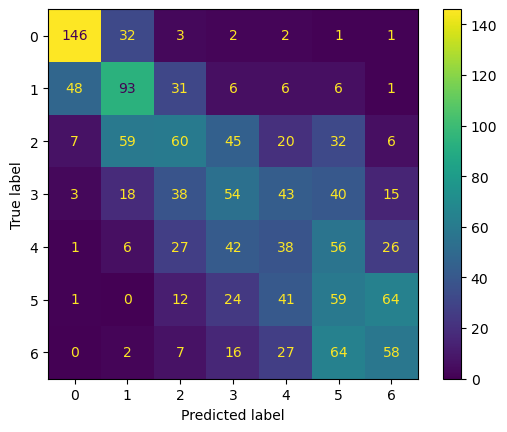

In [27]:
forest.fit(X_train,y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test,y_pred))
plot_confusion_matrix(forest,X_test,y_test);

In [28]:
forest.best_params_

{'forest__criterion': 'entropy',
 'forest__max_depth': None,
 'forest__min_samples_leaf': 2,
 'forest__min_samples_split': 2,
 'forest__n_estimators': 100,
 'sample': RandomOverSampler(random_state=42)}

In [29]:
X = model_df.drop(['Round_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Round_col)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player_col
player_year = X_test.year_col
player_pick = X_test.Pick_col
player_target = X_test.target_col

X_train.drop(['player_col','year_col','Pick_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Pick_col','target_col'],axis=1,inplace=True)

num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('gbc',GradientBoostingClassifier(random_state=42))
])

grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'gbc__n_estimators':[75,100,115],
    'gbc__criterion':['friedman_mse', 'squared_error'],
    'gbc__max_depth':[4,22,None],
    'gbc__min_samples_split':[1,2],
    'gbc__min_samples_leaf':[1,2,3],
    'gbc__learning_rate':[.01,.1,1]
}

gbc = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)


In [30]:
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print(classification_report(y_test,y_pred))
plot_confusion_matrix(gbc,X_test,y_test);

KeyboardInterrupt: 